In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
data = pd.read_csv('data/data_update-2017-10.csv')

In [3]:
import unicodedata

def elimina_tildes(s):
    return ''.join((c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn'))

def descripcion_token(x):
    x = elimina_tildes(x)
    words = ['parrilla','suite','cochera', 'placard', 'terraza',\
             'vestidor', 'patio', 'hall', 'servicio', 'muebles', 'balc', 'jard','acondicionado', \
             'quincho', 'fondo', 'garage', 'parque', 'estrenar', \
             'galer', 'dependencia', 'buena','calefaccion','radiante', 'seguridad', \
             'chalet','gimnasio','vista','calidad','centro','amplio','luminoso','solar','entrega','estilo']
    result = ''
    for word in words:
        if word in x:
            result += '|' + word
    if ('pileta' in x) or ('piscina' in x):
        result += '|' + 'pileta'
    return result
def place_name_from_parent(x): ## Segun vi el 3 item del place es generalmente el lugar
    list = x.split('|')
    if(len(list) < 5):
        return np.nan
    else:
        return list[3]
    
def rescatar_barrios_no_oficiales(x):
    if x == 'Once':
        return ("Balvanera")
    elif x == 'Bajo Belgrano':
        return ("Belgrano")
    elif x == 'Alto Palermo':
        return ("Palermo")
    elif x == 'Tribunales':
        return ("San Nicolás")
    elif x == 'Las Cañitas':
        return("Palermo")
    elif x == 'Capital Federal':
        return(np.nan)
    else:
        return x
    
def recuperar_cant_amb(x):
    "Recupera el dato amb en x (puede ser la descripcion o el titulo)"
    try:
        pos = 0
        x = x.lower()
        if "ambientes" in x:
            pos = x.rfind("ambientes")
        elif "amb" in x:
            pos = x.rfind("amb")
        if pos != 0:
            try:
                return (np.float64(x[pos -2]))
            except ValueError:
                if ("dos amb" in x) or ("dos ambientes" in x):
                    return 2.0
                elif ("tres amb" in x) or ("tres ambientes" in x):
                    return 3.0
                elif ("cuatro amb" in x) or ("cuatro ambientes" in x):
                    return 4.0
                elif ("cinco amb" in x) or ("cinco ambientes" in x):
                    return 5.0
                elif ("seis amb" in x) or ("seis ambientes" in x):
                    return 6.0
                return np.nan
    except AttributeError:
        return None
def contar_ambientes(x):
    "Define la cantidad de ambientes en la descripcion"
    contador = 0
    try:
        x = x.lower()
        if x.rfind("dormitorios") != -1: 
            pos = x.rfind("dormitorios")
        elif x.rfind("habitaciones") != -1:
            pos = x.rfind("habitaciones")
            try:
                contador += (float(x[pos -2])) # intento convertir lo que hay antes de la palabra
                                              #si funciona es el numero de rooms
            except ValueError:
                if ("dos dormitorios" in x) or ("dos habitaciones" in x):
                    contador += 2.0
                elif ("tres dormitorios" in x) or ("tres habitaciones" in x):
                    contador += 3.0
                elif ("cuatro dormitorios" in x) or ("cuatro habitaciones" in x):
                    contador += 4.0
                elif ("cinco dormitorios" in x) or ("cinco habitaciones" in x):
                    contador += 5.0
                elif ("seis dormitorios" in x) or ("seis habitaciones" in x):
                    contador += 6.0
        if ("living" or "comedor") in x:
            contador += 1.0
    except AttributeError:
        return None
    return contador

import re
def precio_from_desc(x):
    try:
        x = x.lower().replace(".","")
        str_price = re.findall("u[s\$][sd] *(\d+)", x)
        if (len(str_price) == 0):
            str_price = re.findall("(\d+) *u[s\$][sd]", x)
        if (len(str_price) > 0):            
            p = float(str_price[0])
            if (p > 2700000.0 or p <= 20000.0):
                    return np.nan
            return p
        return np.nan
    except:
        return np.nan


In [4]:
data.loc[:,'place_name'] = data.place_with_parent_names.apply(place_name_from_parent)## esto quita muchos problemas 
                                                                                    ## de place name como nombres de country
                                                                                    ## o palermo soho
data.loc[data.description.notnull(),'description'] = data.loc[data.description.notnull(),'description'].apply(descripcion_token)


In [5]:
data.loc[:,'place_name'] = data.place_name.apply(rescatar_barrios_no_oficiales)
data['created_on'] = pd.to_datetime(data['created_on']) ## conversion de tipo
data['month'] = data.created_on.apply(lambda x: x.month)
data['year'] = data.created_on.apply(lambda x: x.year)
data['day'] = data.created_on.apply(lambda x: x.day)

In [6]:
data = data[~data.property_type.str.contains('store')]

In [7]:
data.dropna(axis=0,subset=['price_aprox_usd'],inplace=True) ## drop de los datos sin precio
data = data.loc[data['price_aprox_usd'] > 0,:]

In [8]:
data.loc[data.rooms.isnull()| (data.rooms == 0),'rooms'] = data.description.apply(recuperar_cant_amb)
data.loc[data.rooms.isnull()| (data.rooms == 0),'rooms'] = data.title.apply(recuperar_cant_amb)
data.loc[data.rooms.isnull()| (data.rooms == 0),'rooms'] = data.loc[data.rooms.isnull()].description.apply(contar_ambientes)
data.loc[data.surface_total_in_m2.isnull(),'surface_total_in_m2'] = data.surface_covered_in_m2

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276246 entries, 0 to 317037
Data columns (total 26 columns):
id                            276246 non-null object
created_on                    276246 non-null datetime64[ns]
property_type                 276246 non-null object
place_name                    270199 non-null object
place_with_parent_names       276246 non-null object
state_name                    276246 non-null object
geonames_id                   217095 non-null float64
lat-lon                       196422 non-null object
lat                           196422 non-null float64
lon                           196422 non-null float64
price                         276246 non-null float64
currency                      276246 non-null object
price_aprox_local_currency    276246 non-null float64
price_aprox_usd               276246 non-null float64
surface_total_in_m2           258993 non-null float64
surface_covered_in_m2         250068 non-null float64
price_usd_per_m2         

In [10]:
data.describe()

,geonames_id,lat,lon,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,month,year,day
count,2.170950e+05,196422.000000,196422.000000,2.762460e+05,2.762460e+05,2.762460e+05,2.589930e+05,2.500680e+05,1.955600e+05,2.471140e+05,36446.000000,276227.000000,3.550700e+04,276246.000000,276246.000000,276246.000000
mean,3.495914e+06,-34.556873,-58.528887,3.284376e+05,4.170989e+06,2.489405e+05,7.979799e+03,8.169750e+03,1.990728e+03,4.309546e+03,14.535669,1.783222,3.724319e+03,6.419155,2016.227898,17.471515
std,4.349440e+05,1.365496,1.036649,6.557548e+05,5.579327e+06,3.326170e+05,3.929949e+06,3.999465e+06,4.637115e+03,1.564181e+04,105.672435,1.824083,7.538346e+04,2.820344,0.903801,8.623244
min,3.427208e+06,-51.626650,-122.419415,5.000000e+03,4.757708e+04,2.754180e+03,0.000000e+00,0.000000e+00,8.000000e-02,5.000000e-05,1.000000,0.000000,1.000000e+00,1.000000,2012.000000,1.000000
25%,3.429595e+06,-34.629130,-58.579659,1.050000e+05,1.660724e+06,9.900000e+04,4.800000e+01,4.600000e+01,1.122800e+03,1.533333e+03,2.000000,0.000000,1.000000e+03,4.000000,2016.000000,10.000000
50%,3.430786e+06,-34.591772,-58.482191,1.700000e+05,2.677548e+06,1.600000e+05,8.300000e+01,7.600000e+01,1.784906e+03,2.094118e+03,3.000000,2.000000,1.900000e+03,7.000000,2017.000000,19.000000
75%,3.435719e+06,-34.515628,-58.418655,3.200000e+05,4.758613e+06,2.830000e+05,2.000000e+02,1.600000e+02,2.442308e+03,2.884615e+03,6.000000,3.000000,3.883500e+03,8.000000,2017.000000,24.000000
max,6.693230e+06,52.619706,35.202660,1.234568e+08,7.460816e+08,4.654544e+07,2.000000e+09,2.000000e+09,1.271027e+06,2.600000e+06,7071.000000,40.000000,1.000150e+07,12.000000,2017.000000,31.000000


In [11]:
#Filtrar datos anomalos

In [12]:
# Nan para los datos faltantes es mejor que dropear todo el dato 
# Los nros estan masomenos pensados MASOMENOS JEJE
data.loc[(data['surface_total_in_m2']>5000) | (data['surface_total_in_m2'] < 30),'surface_total_in_m2'] = np.nan#5
data.loc[(data['surface_covered_in_m2']>5000),'surface_covered_in_m2'] = np.nan#5k
data.loc[data['floor']>30,'floor'] = np.nan
data.loc[data['rooms']==0,'rooms'] = np.nan
data.loc[data['rooms']>10,'rooms'] = np.nan#10
data.loc[(data['lat']>-33) | (data['lat']<-36),['lat','lon','lat-lon']] = np.nan
data.loc[(data['lon']>-57) | (data['lon']<-60),['lat','lon','lat-lon']] = np.nan
data.loc[(data['expenses']>14000) | (data['expenses']<500),'expenses'] = np.nan

In [13]:
data.describe()

,geonames_id,lat,lon,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,month,year,day
count,2.170950e+05,195758.000000,195758.000000,2.762460e+05,2.762460e+05,2.762460e+05,240175.000000,249962.000000,1.955600e+05,2.471140e+05,35669.000000,167762.000000,30495.000000,276246.000000,276246.000000,276246.000000
mean,3.495914e+06,-34.579944,-58.505984,3.284376e+05,4.170989e+06,2.489405e+05,200.638264,122.239956,1.990728e+03,4.309546e+03,4.443635,2.923201,3057.296081,6.419155,2016.227898,17.471515
std,4.349440e+05,0.111582,0.151836,6.557548e+05,5.579327e+06,3.326170e+05,312.046646,138.700313,4.637115e+03,1.564181e+04,3.846696,1.404890,2577.422652,2.820344,0.903801,8.623244
min,3.427208e+06,-35.765171,-59.664010,5.000000e+03,4.757708e+04,2.754180e+03,30.000000,0.000000,8.000000e-02,5.000000e-05,1.000000,1.000000,500.000000,1.000000,2012.000000,1.000000
25%,3.429595e+06,-34.628813,-58.579659,1.050000e+05,1.660724e+06,9.900000e+04,53.000000,46.000000,1.122800e+03,1.533333e+03,2.000000,2.000000,1200.000000,4.000000,2016.000000,10.000000
50%,3.430786e+06,-34.591734,-58.481808,1.700000e+05,2.677548e+06,1.600000e+05,92.000000,76.000000,1.784906e+03,2.094118e+03,3.000000,3.000000,2100.000000,7.000000,2017.000000,19.000000
75%,3.435719e+06,-34.516081,-58.418533,3.200000e+05,4.758613e+06,2.830000e+05,212.000000,160.000000,2.442308e+03,2.884615e+03,6.000000,4.000000,4000.000000,8.000000,2017.000000,24.000000
max,6.693230e+06,-33.677756,-57.848496,1.234568e+08,7.460816e+08,4.654544e+07,5000.000000,5000.000000,1.271027e+06,2.600000e+06,30.000000,10.000000,14000.000000,12.000000,2017.000000,31.000000


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276246 entries, 0 to 317037
Data columns (total 26 columns):
id                            276246 non-null object
created_on                    276246 non-null datetime64[ns]
property_type                 276246 non-null object
place_name                    270199 non-null object
place_with_parent_names       276246 non-null object
state_name                    276246 non-null object
geonames_id                   217095 non-null float64
lat-lon                       195758 non-null object
lat                           195758 non-null float64
lon                           195758 non-null float64
price                         276246 non-null float64
currency                      276246 non-null object
price_aprox_local_currency    276246 non-null float64
price_aprox_usd               276246 non-null float64
surface_total_in_m2           240175 non-null float64
surface_covered_in_m2         249962 non-null float64
price_usd_per_m2         

In [15]:
# Dropeo las columnas que no se usan porque el test no las tiene o no son necesarias
data.drop(['price','price_usd_per_m2','price_per_m2','currency',\
          'id','created_on','geonames_id','lat-lon','price_aprox_local_currency',\
         'title','place_with_parent_names'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276246 entries, 0 to 317037
Data columns (total 15 columns):
property_type            276246 non-null object
place_name               270199 non-null object
state_name               276246 non-null object
lat                      195758 non-null float64
lon                      195758 non-null float64
price_aprox_usd          276246 non-null float64
surface_total_in_m2      240175 non-null float64
surface_covered_in_m2    249962 non-null float64
floor                    35669 non-null float64
rooms                    167762 non-null float64
expenses                 30495 non-null float64
description              276232 non-null object
month                    276246 non-null int64
year                     276246 non-null int64
day                      276246 non-null int64
dtypes: float64(8), int64(3), object(4)
memory usage: 43.7+ MB


In [16]:
data.dropna(thresh=10,inplace=True)

In [17]:
#Esto es importante, convierto los datos categoricos en numericos cada categoria una columna con 1 si true o 0 si false
##https://stackoverflow.com/questions/34265102/xgboost-categorical-variables-dummification-vs-encoding
##https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/

data = data.join(pd.get_dummies(data.property_type))

data.drop('property_type',axis=1, inplace=True)


data = data.join(data.description.str.get_dummies())
data.drop('description',axis=1, inplace=True)

data = data.join(pd.get_dummies(data.place_name))
data.drop('place_name',axis=1, inplace=True)

data = data.join(pd.get_dummies(data.state_name))
data.drop('state_name',axis=1, inplace=True)

In [18]:
#####XGBOOST
#https://github.com/dmlc/xgboost
#https://xgboost.readthedocs.io/en/latest/build.html
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
#https://www.slideshare.net/ShangxuanZhang/kaggle-winning-solution-xgboost-algorithm-let-us-learn-from-its-author


In [19]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import xgboost as xgb
import scipy.stats as st

from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
#divide el set de datos en parte de entrenamiento y parte de test
# no se puede usar el test bajado de kaggle porque no tiene el precio
X = data.drop(["price_aprox_usd"], axis=1)
Y = data["price_aprox_usd"]

In [21]:
from sklearn.model_selection import GridSearchCV

## Random search de hiperparametros y entrenamiento del algoritmo, 
## ES LA PARTE QUE TARDA
#http://danielhnyk.cz/how-to-use-xgboost-in-python/
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": [200],#nros random desde a hasta b
    "max_depth": [20,22,25],#
    "learning_rate": [0.06], # nros random de una distribucion uniforme entre a y a+b
    "colsample_bytree": [1],
    "subsample": [0.946934], 
    "gamma":[30],
    'reg_alpha': [10],
    "min_child_weight": [11]
}

reg = xgb.XGBRegressor(nthread=2) 

grid = GridSearchCV(reg, params, n_jobs=1,verbose=10,cv=3) # n_iters es la cant de veces que busca, 10 es lo default
grid.fit(X, Y, eval_metric="rmse")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] n_estimators=200, reg_alpha=10, max_depth=20, min_child_weight=11, gamma=30, subsample=0.946934, learning_rate=0.06, colsample_bytree=1 
[CV]  n_estimators=200, reg_alpha=10, max_depth=20, min_child_weight=11, gamma=30, subsample=0.946934, learning_rate=0.06, colsample_bytree=1, score=0.4935839887602725, total=11.0min
[CV] n_estimators=200, reg_alpha=10, max_depth=20, min_child_weight=11, gamma=30, subsample=0.946934, learning_rate=0.06, colsample_bytree=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.4min remaining:    0.0s


[CV]  n_estimators=200, reg_alpha=10, max_depth=20, min_child_weight=11, gamma=30, subsample=0.946934, learning_rate=0.06, colsample_bytree=1, score=0.5637555236328903, total=10.6min
[CV] n_estimators=200, reg_alpha=10, max_depth=20, min_child_weight=11, gamma=30, subsample=0.946934, learning_rate=0.06, colsample_bytree=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 22.4min remaining:    0.0s


KeyboardInterrupt: 

In [217]:
print(grid.best_score_)
#print(grid.best_estimator_)
print(grid.best_params_)
#print(grid.cv_results_)
#0.599467320142
#{'gamma': 30, 'min_child_weight': 11, 'reg_alpha': 10, 'learning_rate': 0.06, 'max_depth': 13, 'n_estimators': 200, 'colsample_bytree': 0.75, 'subsample': 0.7}

#0.591688200046
#{'min_child_weight': 10, 'reg_alpha': 71, 'gamma': 5, 'n_estimators': 200, 'max_depth': 15, 'colsample_bytree': 0.75, 'subsample': 0.85, 'learning_rate': 0.07}

#0.597398358675
#{'gamma': 30, 'min_child_weight': 11, 'reg_alpha': 10, 'learning_rate': 0.07, 'max_depth': 13, 'n_estimators': 200, 'colsample_bytree': 0.75, 'subsample': 0.7}

0.589247321939
{'subsample': 0.7, 'min_child_weight': 11, 'max_depth': 10, 'reg_alpha': 20, 'n_estimators': 200, 'learning_rate': 0.053020977877457624, 'colsample_bytree': 0.75, 'gamma': 30}


In [67]:
print(grid.cv_results_.get('split0_test_score'))

[ 0.51520426  0.51078373]


In [215]:
## Random search de hiperparametros y entrenamiento del algoritmo, 
## cuando termina tira dos scores (no se cual es mejor) y los mejores hiperparametros que dieron esos scores
## ES LA PARTE QUE TARDA
#http://danielhnyk.cz/how-to-use-xgboost-in-python/
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": [200],#nros random desde a hasta b
    "max_depth": [10],
    "learning_rate": st.uniform(0.05,0.013), # nros random de una distribucion uniforme entre a y a+b
    "colsample_bytree": [0.75],
    "subsample": [0.7], 
    "gamma": [30],
    'reg_alpha': [20],
    "min_child_weight": [11]
}

model = xgb.XGBRegressor(nthread=2)

grid = RandomizedSearchCV(model, params, n_jobs=1,n_iter=10,verbose=10) # n_iters es la cant de veces que busca, 10 es lo default
grid.fit(X, Y, eval_metric="rmse")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.0554575863155, colsample_bytree=0.75, gamma=30 
[CV]  subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.0554575863155, colsample_bytree=0.75, gamma=30, score=0.5234066647471836, total= 5.0min
[CV] subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.0554575863155, colsample_bytree=0.75, gamma=30 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.1min remaining:    0.0s


[CV]  subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.0554575863155, colsample_bytree=0.75, gamma=30, score=0.5651783728524247, total= 4.3min
[CV] subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.0554575863155, colsample_bytree=0.75, gamma=30 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.4min remaining:    0.0s


[CV]  subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.0554575863155, colsample_bytree=0.75, gamma=30, score=0.6789174133448477, total= 4.3min
[CV] subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.060785337063, colsample_bytree=0.75, gamma=30 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 13.8min remaining:    0.0s


[CV]  subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.060785337063, colsample_bytree=0.75, gamma=30, score=0.5187586424059787, total= 4.3min
[CV] subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.060785337063, colsample_bytree=0.75, gamma=30 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 18.1min remaining:    0.0s


[CV]  subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.060785337063, colsample_bytree=0.75, gamma=30, score=0.5646985781210393, total= 4.3min
[CV] subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.060785337063, colsample_bytree=0.75, gamma=30 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 22.5min remaining:    0.0s


[CV]  subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.060785337063, colsample_bytree=0.75, gamma=30, score=0.67820969880578, total= 4.3min
[CV] subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.0580518605923, colsample_bytree=0.75, gamma=30 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 26.8min remaining:    0.0s


[CV]  subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.0580518605923, colsample_bytree=0.75, gamma=30, score=0.5209874169055648, total= 4.3min
[CV] subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.0580518605923, colsample_bytree=0.75, gamma=30 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 31.2min remaining:    0.0s


[CV]  subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.0580518605923, colsample_bytree=0.75, gamma=30, score=0.564957613978279, total= 4.3min
[CV] subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.0580518605923, colsample_bytree=0.75, gamma=30 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 35.6min remaining:    0.0s


[CV]  subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.0580518605923, colsample_bytree=0.75, gamma=30, score=0.6780243078082244, total= 4.3min
[CV] subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.0530209778775, colsample_bytree=0.75, gamma=30 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 40.0min remaining:    0.0s


[CV]  subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.0530209778775, colsample_bytree=0.75, gamma=30, score=0.5233056970915424, total= 4.3min
[CV] subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.0530209778775, colsample_bytree=0.75, gamma=30 
[CV]  subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.0530209778775, colsample_bytree=0.75, gamma=30, score=0.5644471292276279, total= 4.3min
[CV] subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.0530209778775, colsample_bytree=0.75, gamma=30 
[CV]  subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.0530209778775, colsample_bytree=0.75, gamma=30, score=0.6799901592644824, total= 4.3min
[CV] subsample=0.7, min_child_weight=11, max_depth=10, reg_alpha=20, n_estimators=200, learning_rate=0.0615969825918, cols

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 131.7min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=2,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'subsample': [0.7], 'reg_alpha': [20], 'max_depth': [10], 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4b0b56a278>, 'n_estimators': [200], 'colsample_bytree': [0.75], 'min_child_weight': [11], 'gamma': [30]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=10)

In [67]:
# Parte para probar los parametros sin random search
# no tarda mucho porque tira el score de la combinacion de parametros que le pones nada mas
X_train, X_test, Y_train, y_test = train_test_split(X, Y,test_size=0.30)
eval_set = [(X_test, y_test)]
xgb = XGBRegressor(colsample_bytree=0.75,gamma=5,learning_rate=0.07,max_depth=9,min_child_weight=1,n_estimators=1000,\
                  reg_alpha=71,subsample=0.85,nthread=2) 

xgb.fit(X_train, Y_train,eval_metric="rmse", eval_set=eval_set,early_stopping_rounds=10, verbose=True)
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
mean_squared_error(y_test, predictions)
xgb.evals_result()


[0]	validation_0-rmse:386779
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:368329
[2]	validation_0-rmse:351247
[3]	validation_0-rmse:336235
[4]	validation_0-rmse:321693
[5]	validation_0-rmse:308744
[6]	validation_0-rmse:298802
[7]	validation_0-rmse:287519
[8]	validation_0-rmse:277311
[9]	validation_0-rmse:267951
[10]	validation_0-rmse:259688
[11]	validation_0-rmse:252186
[12]	validation_0-rmse:245433
[13]	validation_0-rmse:239175
[14]	validation_0-rmse:233642
[15]	validation_0-rmse:227767
[16]	validation_0-rmse:222718
[17]	validation_0-rmse:218446
[18]	validation_0-rmse:214039
[19]	validation_0-rmse:210592
[20]	validation_0-rmse:208273
[21]	validation_0-rmse:205309
[22]	validation_0-rmse:202589
[23]	validation_0-rmse:200076
[24]	validation_0-rmse:197989
[25]	validation_0-rmse:195987
[26]	validation_0-rmse:194051
[27]	validation_0-rmse:192536
[28]	validation_0-rmse:190819
[29]	validation_0-rmse:189094
[30]	validation_0-rmse:187738
[31]	validation

[266]	validation_0-rmse:162892
[267]	validation_0-rmse:162881
[268]	validation_0-rmse:162826
[269]	validation_0-rmse:162824
[270]	validation_0-rmse:162806
[271]	validation_0-rmse:162790
[272]	validation_0-rmse:162782
[273]	validation_0-rmse:162743
[274]	validation_0-rmse:162739
[275]	validation_0-rmse:162731
[276]	validation_0-rmse:162725
[277]	validation_0-rmse:162688
[278]	validation_0-rmse:162670
[279]	validation_0-rmse:162663
[280]	validation_0-rmse:162655
[281]	validation_0-rmse:162631
[282]	validation_0-rmse:162632
[283]	validation_0-rmse:162636
[284]	validation_0-rmse:162614
[285]	validation_0-rmse:162733
[286]	validation_0-rmse:162801
[287]	validation_0-rmse:162765
[288]	validation_0-rmse:162756
[289]	validation_0-rmse:162734
[290]	validation_0-rmse:162728
[291]	validation_0-rmse:162686
[292]	validation_0-rmse:162661
[293]	validation_0-rmse:162607
[294]	validation_0-rmse:162580
[295]	validation_0-rmse:162560
[296]	validation_0-rmse:162523
[297]	validation_0-rmse:162528
[298]	va

{'validation_0': {'rmse': [386779.09375,
   368329.0,
   351247.4375,
   336235.3125,
   321693.25,
   308744.28125,
   298801.875,
   287519.21875,
   277311.0625,
   267950.6875,
   259688.28125,
   252185.859375,
   245432.921875,
   239174.578125,
   233642.421875,
   227767.28125,
   222717.75,
   218445.796875,
   214039.046875,
   210591.703125,
   208273.203125,
   205309.46875,
   202589.28125,
   200076.140625,
   197989.359375,
   195987.1875,
   194050.921875,
   192536.375,
   190819.171875,
   189094.375,
   187738.109375,
   186685.484375,
   185482.328125,
   184247.90625,
   183141.671875,
   182072.484375,
   181357.671875,
   180704.71875,
   180157.234375,
   179423.703125,
   178800.765625,
   178265.390625,
   177736.46875,
   177234.015625,
   176616.5,
   175975.546875,
   175381.59375,
   175045.953125,
   174795.296875,
   174386.703125,
   174062.015625,
   173826.78125,
   173527.96875,
   173233.015625,
   172962.46875,
   172449.671875,
   172248.5625,
   

In [37]:
# Print the rmse score 24415824749.1
#                      51317855617.9
#27872839091.6
#71731022891
#22648919291.2
print(mean_squared_error(Y_test, xgb.predict(X_test)))

29827010463.3


In [21]:
#Prediccion

In [22]:
test = pd.read_csv('data/properati_dataset_testing_noprice.csv')

In [23]:
test.loc[test.state_name.str.contains('Interior'),'place_name'] = 'Palermo'
test.loc[test.state_name.str.contains('Interior'),'state_name'] = 'Capital Federal'
test.loc[test.property_type.str.contains('departamento'),'property_type'] = 'apartment'
test.loc[test.property_type.str.contains('casa'),'property_type'] = 'house'
test.loc[test.property_type.str.contains('ph'),'property_type'] = 'PH'


In [24]:
def convert(s):
    try:
        return float(s)
    except:
        return np.nan

In [25]:
test.loc[test.description.notnull(),'description'] = test.loc[test.description.notnull(),'description'].apply(descripcion_token)
test.loc[:,'place_name'] = test.place_with_parent_names.apply(place_name_from_parent)
test.loc[:,'place_name'] = test.place_name.apply(rescatar_barrios_no_oficiales)
test.loc[test.surface_total_in_m2.isnull(),'surface_total_in_m2'] = test.surface_covered_in_m2
test.loc[test.rooms.isnull()| (test.rooms == 0),'rooms'] = test.description.apply(recuperar_cant_amb)
test.loc[test.rooms.isnull()| (test.rooms == 0),'rooms'] = test.loc[test.rooms.isnull()].description.apply(contar_ambientes)
test['created_on'] = pd.to_datetime(test['created_on']) ## conversion de tipo
test['month'] = test.created_on.apply(lambda x: x.month)
test['year'] = test.created_on.apply(lambda x: x.year)
test['day'] = test.created_on.apply(lambda x: x.day)
test.drop(['id','created_on','operation','lat-lon','place_with_parent_names','country_name'], axis=1, inplace=True)
test.expenses = test.expenses.apply(convert)

In [26]:
test.describe()

,lat,lon,surface_total_in_m2,surface_covered_in_m2,floor,rooms,expenses,month,year,day
count,10487.000000,10487.000000,1.339200e+04,1.300500e+04,1368.000000,14166.000000,2.523000e+03,14166.0,14166.0,14166.000000
mean,-34.629923,-58.465820,3.934301e+02,3.594716e+02,10.679094,1.484893,8.522019e+03,8.0,2017.0,14.021530
std,0.101952,0.164709,2.805803e+04,2.846901e+04,93.466971,1.742398,1.916011e+05,0.0,0.0,8.030705
min,-38.416097,-63.616672,0.000000e+00,1.000000e+00,1.000000,0.000000,0.000000e+00,8.0,2017.0,1.000000
25%,-34.643998,-58.499255,4.600000e+01,4.200000e+01,2.000000,0.000000,1.000000e+03,8.0,2017.0,9.000000
50%,-34.612651,-58.443276,7.200000e+01,6.400000e+01,4.000000,1.000000,2.000000e+03,8.0,2017.0,14.000000
75%,-34.589405,-58.401978,1.450000e+02,1.120000e+02,7.000000,3.000000,3.600000e+03,8.0,2017.0,20.000000
max,-34.536105,-57.900605,3.243242e+06,3.243242e+06,2509.000000,21.000000,7.600072e+06,8.0,2017.0,29.000000


In [27]:
# Nan para los datos faltantes es mejor que dropear todo el dato 
# Los nros estan masomenos pensados MASOMENOS JEJE
test.loc[(test['surface_total_in_m2']>5000) | (test['surface_total_in_m2'] < 30),'surface_total_in_m2'] = np.nan
test.loc[(test['surface_covered_in_m2']>5000),'surface_covered_in_m2'] = np.nan
test.loc[test['floor']>30,'floor'] = np.nan
test.loc[test['rooms']==0,'rooms'] = np.nan
test.loc[test['rooms']>10,'rooms'] = np.nan
test.loc[(test['lat']>-33) | (test['lat']<-36),['lat','lon']] = np.nan
test.loc[(test['lon']>-57) | (test['lon']<-60),['lat','lon']] = np.nan
test.loc[(test['expenses']>14000) | (test['expenses']<500),'expenses'] = np.nan

In [28]:
test.describe()

,lat,lon,surface_total_in_m2,surface_covered_in_m2,floor,rooms,expenses,month,year,day
count,10483.000000,10483.000000,12817.000000,12998.000000,1354.000000,7490.000000,2204.000000,14166.0,14166.0,14166.000000
mean,-34.628479,-58.463854,134.013654,95.626943,5.118907,2.788919,2969.823503,8.0,2017.0,14.021530
std,0.070184,0.130426,187.645059,126.166300,4.215539,1.355359,2471.028712,0.0,0.0,8.030705
min,-35.123100,-58.975341,30.000000,1.000000,1.000000,1.000000,500.000000,8.0,2017.0,1.000000
25%,-34.643941,-58.499089,48.000000,42.000000,2.000000,2.000000,1200.000000,8.0,2017.0,9.000000
50%,-34.612629,-58.443256,75.000000,64.000000,4.000000,3.000000,2100.000000,8.0,2017.0,14.000000
75%,-34.589392,-58.401970,150.000000,111.000000,7.000000,4.000000,3800.000000,8.0,2017.0,20.000000
max,-34.536105,-57.900605,4810.000000,4733.000000,29.000000,10.000000,14000.000000,8.0,2017.0,29.000000


In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14166 entries, 0 to 14165
Data columns (total 14 columns):
property_type            14166 non-null object
place_name               13901 non-null object
state_name               14166 non-null object
lat                      10483 non-null float64
lon                      10483 non-null float64
surface_total_in_m2      12817 non-null float64
surface_covered_in_m2    12998 non-null float64
floor                    1354 non-null float64
rooms                    7490 non-null float64
expenses                 2204 non-null float64
description              14166 non-null object
month                    14166 non-null int64
year                     14166 non-null int64
day                      14166 non-null int64
dtypes: float64(7), int64(3), object(4)
memory usage: 1.5+ MB


In [30]:
test = test.join(pd.get_dummies(test.property_type))
test.drop('property_type',axis=1, inplace=True)
test = test.join(test.description.str.get_dummies())
test.drop('description',axis=1, inplace=True)
test = test.join(pd.get_dummies(test.place_name))
test.drop('place_name',axis=1, inplace=True)
test = test.join(pd.get_dummies(test.state_name))
test.drop('state_name',axis=1, inplace=True)

In [31]:
tot = pd.concat([X,test])
tot.reset_index(inplace=True,drop=True)

In [32]:
test_2 = tot[(len(tot)-len(test)):]
test_2.reset_index(inplace=True,drop=True)

In [33]:
test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14166 entries, 0 to 14165
Columns: 141 entries, Abasto to year
dtypes: float64(19), int64(38), uint8(84)
memory usage: 7.3 MB


In [34]:
test_2 = test_2[X.columns]

In [35]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266951 entries, 0 to 317037
Columns: 141 entries, lat to Capital Federal
dtypes: float64(7), int64(38), uint8(96)
memory usage: 128.1 MB


In [36]:
#model = xgb.XGBRegressor()
#bst = xgb.Booster()
#bst.load_model('24_11_b.model')
#model._Booster = bst

In [56]:
#{'n_estimators': 200, 'subsample': 0.8, 'reg_alpha': 0, 'min_child_weight': 1, 'learning_rate': 0.1, 'gamma': 0, 'max_depth': 9, 'colsample_bytree': 0.8}

#X_train, X_test, Y_train, y_test = train_test_split(X, Y,test_size=0.06)
#eval_set = [(X_test, y_test)]
#model = xgb.XGBRegressor(colsample_bytree=1,gamma=50,learning_rate=0.06,max_depth=25,min_child_weight=15,n_estimators=1000,\
 #                 reg_alpha=10,subsample=0.946934,nthread=2) 

#model.fit(X_train, Y_train,eval_metric="rmse", eval_set=eval_set,early_stopping_rounds=15, verbose=True)
#0.599467320142
#{'gamma': 30, 'min_child_weight': 11, 'reg_alpha': 10, 'learning_rate': 0.06, 'max_depth': 13, 'n_estimators': 200, 'colsample_bytree': 0.75, 'subsample': 0.7}
import datetime
a = datetime.datetime.now()

model = xgb.XGBRegressor(colsample_bytree=1,gamma=50,learning_rate=0.06,max_depth=40,min_child_weight=15,n_estimators=200,\
                 reg_alpha=10,subsample=0.946934,nthread=2)

model.fit(X, Y,eval_metric="rmse", verbose=True)
b = datetime.datetime.now()
print(b-a)

0:32:36.019404


In [57]:
model.booster().save_model('26_11_c.model')

In [58]:
pred = model.predict(test_2)

In [58]:
df = pd.DataFrame.from_dict(model.booster().get_score(),orient='index')
df.columns=['FScore']

Parque Avellaneda            1
Villa Santa Rita             2
Parque Chas                  2
Villa General Mitre          3
Abasto                       4
Parque Centenario            5
Villa Ortuzar                6
Pompeya                      8
Cañuelas                     8
Villa Pueyrredón            12
San Vicente                 13
Monte Castro                19
Florencio Varela            23
Villa del Parque            27
Liniers                     46
Paternal                    47
Villa Lugano                48
Chacarita                   54
Colegiales                  62
Centro / Microcentro        63
Floresta                    64
Parque Patricios            64
Parque Chacabuco            80
Hurlingham                  87
Presidente Perón            88
Monserrat                   97
José C Paz                 100
Coghlan                    123
Avellaneda                 130
Congreso                   131
                         ...  
apartment                 2808
calidad 

<IPython.core.display.Javascript object>


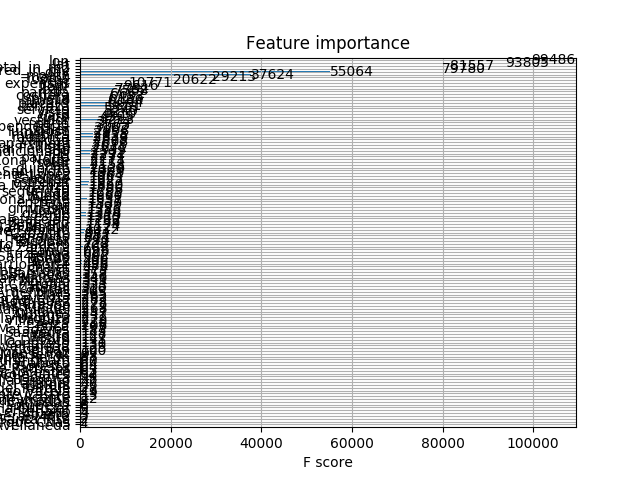

In [54]:
xgb.plot_importance(model,importance_type='weight')

In [59]:
pred

array([ 663429.0625  ,  201475.53125 ,  200877.234375, ...,  185943.046875,
        187851.625   ,  181472.890625], dtype=float32)

In [46]:
#test_f = pd.read_csv('data/properati_dataset_testing_noprice.csv')
#test_f['precio_from_desc'] = test_f.description.apply(precio_from_desc
pred

array([ 639243.375   ,  272335.59375 ,  196644.8125  , ...,  195608.28125 ,
        182609.578125,  189241.5     ], dtype=float32)

In [148]:
#array([ 566896.25    ,  152779.84375 ,  172354.0625  , ...,  191947.265625,
        188483.578125,  181000.046875], dtype=float32)

array([ 684291.1875  ,  231789.859375,  193501.59375 , ...,  176725.890625,
        210647.796875,  151377.171875], dtype=float32)

In [60]:
test_e = pd.read_csv('data/properati_dataset_testing_noprice.csv')
test_e['precio_from_desc'] = test_e.description.apply(precio_from_desc)
test_e['price_usd'] = pred
test_e.loc[test_e.precio_from_desc.notnull() & ((abs(pred-test_e.precio_from_desc)/pred)<0.6),'price_usd'] = test_e['precio_from_desc']
test_e = test_e.loc[:,['id','price_usd']]
test_e.to_csv('Predicciones/XgBoost_10_26_d.csv', index = False)

In [62]:
best = pd.read_csv('Predicciones/XgBoost_10_26_a.csv')
sum(abs(best['price_usd']-test_e.price_usd))

130250098.58361816

In [53]:
#125431638
#339920403
#346613952
#222818644.19671631
#219486415.57104492
test_e.price_usd

0        570000.000000
1        198475.546875
2        186107.906250
3         96437.976562
4        120842.171875
5         96437.976562
6         96437.976562
7         96437.976562
8        155896.609375
9        118132.421875
10       118132.421875
11       118132.421875
12       321325.125000
13       742235.312500
14       103178.968750
15       103178.968750
16       103178.968750
17       103178.968750
18       103178.968750
19       103178.968750
20       103178.968750
21       103178.968750
22       129013.656250
23       126766.765625
24       126766.765625
25       126766.765625
26       126766.765625
27       103178.968750
28       103178.968750
29        93763.726562
             ...      
14136    105381.750000
14137     74279.601562
14138    177895.828125
14139    230960.953125
14140    127511.625000
14141    204696.968750
14142    124133.578125
14143    106605.179688
14144    257672.750000
14145    119786.562500
14146    116990.703125
14147     98648.398438
14148    15

In [64]:
test_e.drop('description',axis=1,inplace=True)

In [65]:
test_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14166 entries, 0 to 14165
Data columns (total 2 columns):
id           14166 non-null int64
price_usd    14166 non-null float32
dtypes: float32(1), int64(1)
memory usage: 166.1 KB


In [2]:
ff = pd.read_csv('Predicciones/XgBoost_2.csv')
pred = ff['price_usd']

AttributeError: 'Series' object has no attribute 'info'

In [7]:
test_e = pd.read_csv('data/properati_dataset_testing_noprice.csv')
test_e['precio_from_desc'] = test_e.description.apply(precio_from_desc)
test_e['price_usd'] = pred
test_e.loc[test_e.precio_from_desc.notnull() & (abs(100-test_e.precio_from_desc*100/test_e.price_usd) < 30),'price_usd'] = test_e['precio_from_desc']
test_e = test_e.loc[:,['id','price_usd']]
test_e.to_csv('Predicciones/XgBoost_2_b.csv', index = False)

In [8]:
test_e.to_csv('Predicciones/XgBoost_2_b.csv', index = False)

In [156]:
test_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14166 entries, 0 to 14165
Data columns (total 2 columns):
id           14166 non-null int64
price_usd    14166 non-null float32
dtypes: float32(1), int64(1)
memory usage: 166.1 KB


In [197]:
test_e = pd.read_csv('data/properati_dataset_testing_noprice.csv')

In [175]:
test_e.iloc[5].description

'                AMBIENTE DIVISIBLE CON PISOS DE PORCELANATO NATURAL CON ZÓCALOS DE MADERA COLOR WENGUE- AMPLIO BAÑO COMPLETO REVESTIDO CON CERÁMICA SAN LORENZO COLOR ARENA Y GUARDAS DE VENECITAS- ARTEFACTOS SANITARIOS Y GRIFERÍAS SERÁN DE MARCAS DE PRIMERA LÍNEA (ROCA, GENEBRE, FERRUM O SIMILAR)- PLACARD COMPLETO-COCINA CON MESADA DE GRANITO, MUEBLES BAJO Y SOBRE MESADA COMPLETOS-  COCINA CON HORNO Y ANAFE DE 4 HORNALLAS A GAS- PRE-INSTALACIÓN PARA EQUIPOS DE AIRE ACONDICIONADOAGUA CALIENTE CENTRAL-BALCÓN CON CONEXIÓN PARA LAVARROPAS- AMENITIES: SOLÁRIUM CON PARRILLA.ENTREGA SEPTIEMBRE 2018PRECIO DE CONTADO- CONSULTAR POR FINANCIACIÓN ADELANTO DE 35% Y CUOTAS CON AJUSTE CAC.COCHERAS OPCIONALES DESDE u$s20.000.-BAULERAS OPCIONALES u$S2.200.-CONSÚLTENOS- SUCURSAL PALERMO-             Excelencia en Servicios Inmobiliarios, desde 1972.'

In [206]:
test_e['precio_from_desc'] = test_e.description.apply(precio_from_desc)

In [207]:
test_e.sort_values(by='precio_from_desc',ascending=True).head(20)

,id,created_on,property_type,operation,place_name,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,surface_total_in_m2,surface_covered_in_m2,floor,rooms,expenses,description,precio_from_desc
4638,2289157,2017-08-11,departamento,venta,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,"-34.6427936,-58.5117661",-34.642794,-58.511766,55.0,50.0,NaN,3.0,NaN,Se ofrecen a la venta dos unidades de tres amb...,125.0
1572,2273266,2017-08-05,departamento,venta,Flores,|Argentina|Capital Federal|Flores|,Argentina,Capital Federal,"-34.618926,-58.461959",-34.618926,-58.461959,176.0,157.0,NaN,5.0,NaN,Corredor Responsable: Rebeca Stern - C.U.C.I.C...,147.0
4653,2289184,2017-08-11,departamento,venta,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,"-34.6505806,-58.5182644",-34.650581,-58.518264,100.0,84.0,NaN,3.0,NaN,PRIMER PISO -3amb. Al frente 100m2 totales U$S...,250.0
829,2268333,2017-08-02,departamento,venta,Palermo Soho,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,"-34.5854083675,-58.4269523302",-34.585408,-58.426952,91.0,70.0,NaN,NaN,5500,VENTA DEPARTAMENTO DE 3 AMBIENTES EN PALERO CO...,265.0
821,2268312,2017-08-02,departamento,venta,Palermo Soho,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,"-34.5901346135,-58.43209812",-34.590135,-58.432098,104.0,73.0,NaN,NaN,NaN,VENTA DEPARTAMENTO 3 AMBIENTES EN PALERMO SOHO...,315.0
2531,2279130,2017-08-09,departamento,venta,San Cristobal,|Argentina|Capital Federal|San Cristobal|,Argentina,Capital Federal,"-34.6237771,-58.4022249",-34.623777,-58.402225,52.0,52.0,13.0,1.0,NaN,Zona:Buena-Asfalto-Osn:Cloaca-Lavadero-Medidas...,350.0
2532,2279131,2017-08-09,departamento,venta,San Cristobal,|Argentina|Capital Federal|San Cristobal|,Argentina,Capital Federal,"-34.6237771,-58.4022249",-34.623777,-58.402225,52.0,52.0,13.0,1.0,NaN,Zona:Buena-Asfalto-Osn:Cloaca-Lavadero-Medidas...,350.0
5026,2290737,2017-08-11,departamento,venta,Palermo Soho,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,"-34.5900996057,-58.4302024449",-34.590100,-58.430202,160.0,130.0,NaN,NaN,4000,VENTA DUPLEX 4 AMBIENTES EN PALERMO SOHO / CON...,410.0
12185,2183588,2017-08-01,casa,venta,Lomas de Zamora,|Argentina|Bs.As. G.B.A. Zona Sur|Lomas de Zam...,Argentina,Bs.As. G.B.A. Zona Sur,"-34.7722138,-58.4309831",-34.772214,-58.430983,385.0,190.0,NaN,NaN,NaN,Venta de Casa 5 AMBIENTES CON COCHERA Y FOND...,418.0
7513,2304678,2017-08-17,casa,venta,Capital Federal,|Argentina|Capital Federal|,Argentina,Capital Federal,NaN,NaN,NaN,NaN,340.0,NaN,NaN,5000,USD 480 mil. o alquilo amueblado por dos años ...,480.0


In [204]:
test_e.iloc[89].description

'Excelente departamento ubicado en lo mejor de Av. Del Libertador, Cuenta con Living comedor, con vista abierta, balcón corrido al frente . Sus tres dormitorios cuenta con balcón corrido (contrafrente) con vista al rio al igual que la cocina- comedor.Posee amplio lavadero , un baño completo y un toa Excelente luz natural, y vista.Cuenta con cochera fija, con capacidad para dos autos , mas baulera. Puerta Blindada en la entrada principal.Impecable y en lo mejor de Belgrano!!!- Se deja constancia que los m2 indicados son aproximados, al igual que las medidas parciales de los ambientes, y el valor consignado de expensas mensuales está sujeto a verificación y/o ajustes.Fotos de carácter no contractual -Consúltenos.'